In [1]:
import numpy as np
from cats.cdataframe import CDataFrame 
from os.path         import exists
import ROOT
from ROOT            import TCanvas
from pprint          import pprint

import rawio
from scipy.signal import butter, lfilter
import matplotlib.pyplot as plt
import re

%jsroot off

Welcome to JupyROOT 6.28/10


In [2]:
# Set up canvas

# Create a canvas to draw on
c = TCanvas(
    "c", # Name for ROOT to use internally
    "",       # Title (not visible)
    800,      # Width
    600       # Height
)

In [3]:
chanNames=["PAS1","PBS1","PCS1","PDS1","PES1","PFS1","PAS2","PBS2","PCS2","PDS2","PES2","PFS2"]
#chanNames=["PBS1","PCS1","PDS1","PES1","PFS1","PAS2","PBS2","PCS2","PDS2","PES2","PFS2"] # T3Z3 doesn't have PAS1

In [4]:
# Figure out data directory

rootDir_s3df = "/fs/ddn/sdf/group/supercdms"
rootDir_drac = "/project/rrg-mdiamond"
relDir       = "/data/CDMS/CUTE/R37/Processed/Prompt/Prompt_V04-15_P0.2.1/Submerged"

if   exists(rootDir_s3df): dataDir = rootDir_s3df + relDir
elif exists(rootDir_drac): dataDir = rootDir_drac + relDir
else: raise Exception("Couldn't find data directory?  Are you not on S3DF or ComputeCanada?")

In [5]:
# extract dataframe from a RQ file

def get_df(dataDir, series):
    """
    Get df from a series. No cuts applied(?)

    Parameters:
    dataDir: directory path
    series: series name

    Returns:
    data frame

    """
    filepath = f"{dataDir}/Prompt_V04-15_P0.2.1_{series}.root"

    #filepath = "/sdf/home/y/yanliu/data/cute/Ba_post_2nd_bake.root"
    #filepath = "/sdf/home/y/yanliu/data/cute/Ba_post_3rd_bake.root"
    #filepath = "/sdf/home/y/yanliu/data/cute/Ba_post_4th_bake.root"
    #filepath = "/sdf/home/y/yanliu/data/cute/Ba_post_5th_bake.root"
    #filepath = "/sdf/home/y/yanliu/data/cute/Ba_post_6th_bake.root"

    #filepath = "/sdf/home/y/yanliu/data/cute/Ba_post_2nd_bake_partial.root"
    #filepath = "/sdf/scratch/users/y/yanliu/data/cute/Ba_post_6th_bake.root"
    #filepath = "/sdf/home/y/yanliu/data/cute/23240106_175250.root"
    #filepath = "/sdf/scratch/users/y/yanliu/data/cute/Ba_post_6th_bake_Z2HV_ongoing.root"
    #filepath = "/sdf/home/y/yanliu/data/cute/Ba_combine_post_2ndand6th_bake_Z2HV.root"
    filepath = "/sdf/scratch/users/y/yanliu/data/cute/public/Ba_Z2_0V_calibration_20240128.root"


    #filepath = "~/delete.root"
    # One CDataframe per detector, identified by detector number (1-6)
    dfs_orig = {
        det: CDataFrame(f"rqDir/zip{det}", filepath, [f"{filepath}:rqDir/eventTree"])
        for det in range(1, 6+1)
    }

    return dfs_orig

def butter_lowpass_filter(data, cutoff_frequency, sampling_rate=625000, order=4): # cutoff_frequency in kHz
    cutoff_frequency *= 1000
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_frequency / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = lfilter(b, a, data)
    return y

In [6]:
def plot_raw_traces(events, det, chanNames=["PAS1","PBS1","PCS1","PDS1","PES1","PFS1","PAS2","PBS2","PCS2","PDS2","PES2","PFS2"], 
                    plot_title="", zoom=True, tracelength=32768, filter = "butter",
                    low_bound=1000, up_bound=32000, sampling_interval=1/625):
    """
    Plot raw traces from a rawio event object.

    Parameters:
    - events: event object from RawDataReader.read_events()
    - det: which detector
    - chanNames: list of channel names
    - plot_title: title of the plot, default left empty
    - zoom: whether to use zoom-in version (23 to 32 ms) or full tracelength
    - tracelength: 32768 hardcode??
    - filter: avaialble ones: butter or none. 
    - low_bound: lower bound for the plot
    - up_bound: upper bound for the plot
    - sampling_interval: time between samples

    Returns:
    - matplotlib plot(?)
    """
    pt_events = []
    use_default_title = True

    if not zoom:
        low_bound = 0
        up_bound = tracelength

    if len(plot_title)!=0:
        use_default_title = False
        

    time = np.arange(0, tracelength * sampling_interval, sampling_interval)

    for id in range(len(events)):
        #print (id)
        traces = events[id]["Z"+str(det)]

        plt.figure(figsize=(10, 4))
        if use_default_title:    
            plot_title="Raw traces for "+str(events[id]["event"]["SeriesNumber"])+" event "+str(events[id]["event"]["EventNumber"])            
        plt.title(plot_title)

        pt = np.zeros(tracelength)
        ctr = 0

        for chan in chanNames:
            pt += traces[chan]
            ctr += 1
            if (filter=="butter"):
                plt.plot(time[low_bound:up_bound], butter_lowpass_filter(traces[chan], 10)[low_bound:up_bound], label=chan, linewidth=1)
            elif (filter=="none"):
                plt.plot(time[low_bound:up_bound], traces[chan][low_bound:up_bound], label=chan, linewidth=1)
            else:
                print("unknown filter")

        pt /= ctr
        pt_events.append(pt)

        plt.xlabel("Time (ms)")
        plt.ylabel("ADC count")
        plt.legend()
        plt.show()

    return pt_events  # You might want to return something meaningful here

In [7]:
# Making timestamps relative to start of series, not 1970
def t0(df): return df.Filter("rdfentry_ == 1").AsNumpy(["EventTime"])["EventTime"][0]

In [8]:
def extract_eqn(f):
    eqn = str(f.GetExpFormula())
    placeholders = re.findall(r'\[[^\[\]]*\]', eqn)
    for i,char in enumerate(placeholders,0):
        val = f.GetParameters()[i]
        eqn = eqn.replace(char,str(val))        
    return eqn

def make_cut(f,x_rq,y_rq):
    eqn = extract_eqn(f)
    eqn = eqn.replace('x',x_rq)
    cut = f'{eqn}>{y_rq}'
    return cut

In [9]:
# Series list

series_dict = {
    "23231228_182306" : "post_3rd_bake",
    "23231230_111531" : "post_4th_bake",
    "23231230_205226" : "post_4th_bake_alldetstrig",
    "23231231_145256" : "post_5th_bake_alldetstrig",
    "23240101_075600" : "post_5th_bake_alldetstrig",
    "post_2nd_bake"   : "post_2nd_bake combined",
    "post_3rd_bake"   : "post_3rd_bake combined",
    "post_4th_bake"   : "post_4th_bake combined (previous trigger)",
    "post_5th_bake"   : "post_5th_bake combined",
    "23240103_072548" : "low bg 23240103_072548 post_6th_bake cooling down",
    "23240103_151214" : "low bg 23240103_151214 post_6th_bake",
    "23240103_200057" : "low bg 23240103_200057 post_6th_bake",
    "23240104_013437" : "low bg 23240104_013437 post_6th_bake",
    "23240104_133208" : "23240104_133208 post_6th_bake",
    "23240105_004411" : "23240105_004411 post_6th_bake lower threshold",
    "23240105_062513" : "23240105_062513 post_6th_bake lower threshold",
    "23240105_120616" : "23240105_120616 post_6th_bake lower threshold",
    "23240106_175250" : "23240106_175250 post 2nd_miniflash",
    "23240106_233351" : "23240106_233351 post_6th_bake lower threshold",
    "23240107_051453" : "23240107_051453 post_6th_bake lower threshold",
    "post_6th_bake_og": "post_6th_bake_ongoing",
    "23240109_021236" : "23240109_021236 post_6th_bake lower threshold",
    "23240109_093619" : "23240109_093619 Z2 baseline resolution",
    "23240109_101201" : "23240109_101201 Z2 baseline resolution",
    "23240109_105340" : "23240109_105340 Z2 baseline resolution",
    "23240109_021236" : "23240109_021236 Z2 baseline resolution",
    "23240109_114501" : "23240109_114501",
    "23240109_124807" : "23240109_124807 Z2 baseline resolution",
    "23240109_154130" : "23240109_154130 Z2HV first series",
    "23240109_133635" : "23240109_133635 old IbIs LED",
    "23240109_131408" : "23240109_131408 new IbIs LED",
    "23240101_210105" : "23240101_210105 LED post 5th bake",
    "post_6th_bake"   : "post_6th_bake combined",
    "post_6th_bake_Z2HV_og" : "post_6th_bake_Z2HV_ongoing",
    "23240111_073252" : "23240111_073252",
    "23240112_123746" : "23240112_123746",
    "post_2ndand6th_bake_combined" : "post_2ndand6th_bake_combined",
    "23240102_071256" : "23240102_071256 low bg 90V Z2",
    "23240115_202511" : "23240115_202511",
    "23240118_023749" : "23240118_023749",
    "23240117_063039" : "23240117_063039",
    "23240117_121348" : "23240117_121348",
    "23240115_202511" : "23240115_202511",
    "23240118_153016" : "23240118_153016",
    "23240118_214720" : "23240118_214720",
    "23240119_111659" : "23240119_111659",
    "23240108_203134" : "23240108_203134",
    "23240123_135038" : "23240123_135038",
    "Ba_Z2_0V_calibration_20240128" : "Ba_Z2_0V_calibration_20240128"
}

for key, series in series_dict.items():
    print(key, series)

series = "Ba_Z2_0V_calibration_20240128"
#series = "post_6th_bake_Z2HV_og" # hardcode here
det = 2
print (series_dict[series])
df = get_df(dataDir, series)

23231228_182306 post_3rd_bake
23231230_111531 post_4th_bake
23231230_205226 post_4th_bake_alldetstrig
23231231_145256 post_5th_bake_alldetstrig
23240101_075600 post_5th_bake_alldetstrig
post_2nd_bake post_2nd_bake combined
post_3rd_bake post_3rd_bake combined
post_4th_bake post_4th_bake combined (previous trigger)
post_5th_bake post_5th_bake combined
23240103_072548 low bg 23240103_072548 post_6th_bake cooling down
23240103_151214 low bg 23240103_151214 post_6th_bake
23240103_200057 low bg 23240103_200057 post_6th_bake
23240104_013437 low bg 23240104_013437 post_6th_bake
23240104_133208 23240104_133208 post_6th_bake
23240105_004411 23240105_004411 post_6th_bake lower threshold
23240105_062513 23240105_062513 post_6th_bake lower threshold
23240105_120616 23240105_120616 post_6th_bake lower threshold
23240106_175250 23240106_175250 post 2nd_miniflash
23240106_233351 23240106_233351 post_6th_bake lower threshold
23240107_051453 23240107_051453 post_6th_bake lower threshold
post_6th_bake_o

### Command to merge Z2 0V calibration files:
hadd Ba_Z2_0V_calibration_20240128.root /fs/ddn/sdf/group/supercdms/data/CDMS/CUTE/R37/Processed/Prompt/Prompt_V04-15_P0.2.1/Submerged/Prompt_V04-15_P0.2.1_23240104_133208.root /fs/ddn/sdf/group/supercdms/data/CDMS/CUTE/R37/Processed/Prompt/Prompt_V04-15_P0.2.1/Submerged/Prompt_V04-15_P0.2.1_23240104_191311.root /fs/ddn/sdf/group/supercdms/data/CDMS/CUTE/R37/Processed/Prompt/Prompt_V04-15_P0.2.1/Submerged/Prompt_V04-15_P0.2.1_23240105_004411.root /fs/ddn/sdf/group/supercdms/data/CDMS/CUTE/R37/Processed/Prompt/Prompt_V04-15_P0.2.1/Submerged/Prompt_V04-15_P0.2.1_23240105_062513.root /fs/ddn/sdf/group/supercdms/data/CDMS/CUTE/R37/Processed/Prompt/Prompt_V04-15_P0.2.1/Submerged/Prompt_V04-15_P0.2.1_23240105_120616.root /fs/ddn/sdf/group/supercdms/data/CDMS/CUTE/R37/Processed/Prompt/Prompt_V04-15_P0.2.1/Submerged/Prompt_V04-15_P0.2.1_23240105_174716.root /fs/ddn/sdf/group/supercdms/data/CDMS/CUTE/R37/Processed/Prompt/Prompt_V04-15_P0.2.1/Submerged/Prompt_V04-15_P0.2.1_23240105_232818.root /fs/ddn/sdf/group/supercdms/data/CDMS/CUTE/R37/Processed/Prompt/Prompt_V04-15_P0.2.1/Submerged/Prompt_V04-15_P0.2.1_23240106_050919.root /fs/ddn/sdf/group/supercdms/data/CDMS/CUTE/R37/Processed/Prompt/Prompt_V04-15_P0.2.1/Submerged/Prompt_V04-15_P0.2.1_23240106_105019.root /fs/ddn/sdf/group/supercdms/data/CDMS/CUTE/R37/Processed/Prompt/Prompt_V04-15_P0.2.1/Submerged/Prompt_V04-15_P0.2.1_23240106_175250.root /fs/ddn/sdf/group/supercdms/data/CDMS/CUTE/R37/Processed/Prompt/Prompt_V04-15_P0.2.1/Submerged/Prompt_V04-15_P0.2.1_23240106_233351.root /fs/ddn/sdf/group/supercdms/data/CDMS/CUTE/R37/Processed/Prompt/Prompt_V04-15_P0.2.1/Submerged/Prompt_V04-15_P0.2.1_23240107_051453.root /fs/ddn/sdf/group/supercdms/data/CDMS/CUTE/R37/Processed/Prompt/Prompt_V04-15_P0.2.1/Submerged/Prompt_V04-15_P0.2.1_23240107_105555.root /fs/ddn/sdf/group/supercdms/data/CDMS/CUTE/R37/Processed/Prompt/Prompt_V04-15_P0.2.1/Submerged/Prompt_V04-15_P0.2.1_23240107_163656.root /fs/ddn/sdf/group/supercdms/data/CDMS/CUTE/R37/Processed/Prompt/Prompt_V04-15_P0.2.1/Submerged/Prompt_V04-15_P0.2.1_23240107_221758.root /fs/ddn/sdf/group/supercdms/data/CDMS/CUTE/R37/Processed/Prompt/Prompt_V04-15_P0.2.1/Submerged/Prompt_V04-15_P0.2.1_23240108_035901.root /fs/ddn/sdf/group/supercdms/data/CDMS/CUTE/R37/Processed/Prompt/Prompt_V04-15_P0.2.1/Submerged/Prompt_V04-15_P0.2.1_23240108_094004.root /fs/ddn/sdf/group/supercdms/data/CDMS/CUTE/R37/Processed/Prompt/Prompt_V04-15_P0.2.1/Submerged/Prompt_V04-15_P0.2.1_23240108_152106.root
hadd Target file: Ba_Z2_0V_calibration_20240128.root

In [10]:
#            "PFS1", "PCS1", "PDS1", "PBS1", "PES1", "PAS1", "PFS2", "PCS2", "PBS2", "PES2", "PDS2", "PAS2"
calib_rel = [0.7981, 1.284, 0.9174, 0.9633, 1.0092, 1.1192, 0.7996, 1.0521, 0.9427, 0.9258, 0.8417, 1.3467]

# create a new column that has radial info
df[det] = df[det].Define("R_timediff","(PFS1OFdelay-PAS1OFdelay)/1.6e-6")
#df[det] = df[det].Define("R_timediff","(PFS2OFdelay-PAS2OFdelay)/1.6e-6")

df[det] = df[det].Define("EventTime_rel",f"EventTime-{t0(df[det])}")


#df[det] = df[det].Define("PTSumamps", "PAS1OFamps+PBS1OFamps+PCS1OFamps+PDS1OFamps+PES1OFamps+PFS1OFamps+PAS2OFamps+PBS2OFamps+PCS2OFamps+PDS2OFamps+PES2OFamps+PFS2OFamps")
#df[det] = df[det].Define("PTSumamps", "(PAS1OFamps+PBS1OFamps+PDS1OFamps+PES1OFamps+PFS1OFamps+PAS2OFamps+PBS2OFamps+PCS2OFamps+PDS2OFamps+PES2OFamps+PFS2OFamps)*12.0/11.0")
#df[det] = df[det].Define("PTSumamps", "PAS1OFamps+PBS1OFamps+PCS2OFamps+PDS1OFamps+PES1OFamps+PFS1OFamps+PAS2OFamps+PBS2OFamps+PCS2OFamps+PDS2OFamps+PES2OFamps+PFS2OFamps")
#df[det] = df[det].Define("PTSumamps0", "PAS1OFamps0+PBS1OFamps0+PCS1OFamps0+PDS1OFamps0+PES1OFamps0+PFS1OFamps0+PAS2OFamps0+PBS2OFamps0+PCS2OFamps0+PDS2OFamps0+PES2OFamps0+PFS2OFamps0")

#df[det] = df[det].Define("PTSumamps", "1.1192*PAS1OFamps+0.9633*PBS1OFamps+1.284*PCS2OFamps+0.9174*PDS1OFamps+1.0092*PES1OFamps+0.7981*PFS1OFamps+1.3467*PAS2OFamps+0.9427*PBS2OFamps+1.0521*PCS2OFamps+0.8417*PDS2OFamps+0.9258*PES2OFamps+0.7996*PFS2OFamps")
#df[det] = df[det].Define("PTSumamps0", "1.1192*PAS1OFamps0+0.9633*PBS1OFamps0+1.284*PCS1OFamps0+0.9174*PDS1OFamps0+1.0092*PES1OFamps0+0.7981*PFS1OFamps0+1.3467*PAS2OFamps0+0.9427*PBS2OFamps0+1.0521*PCS2OFamps0+0.8417*PDS2OFamps0+0.9258*PES2OFamps0+0.7996*PFS2OFamps0")

In [11]:
#df[det] = df[det].Filter("SeriesNumber!=23240112011558")\
#                 .Filter("SeriesNumber>=23240111143943")

 FCN=3088.84 FROM MIGRAD    STATUS=CONVERGED     103 CALLS         104 TOTAL
                     EDM=7.76467e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     3.14510e+03   2.41283e+01   4.97524e-01   1.88334e-05
   2  Mean        -9.52740e-10   2.17637e-10   5.90689e-12   8.55655e+05
   3  Sigma        3.73411e-08   1.86199e-10   2.04097e-05   3.37508e-01


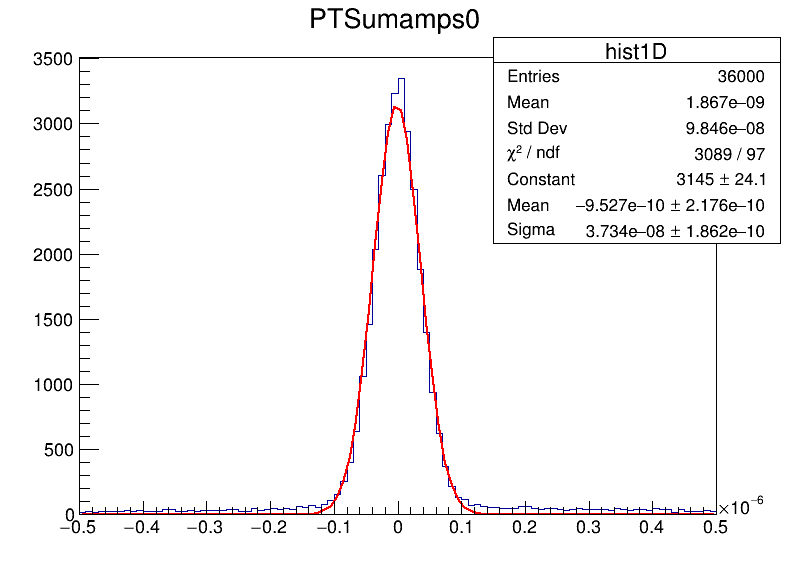

In [12]:
h = df[det].Filter("TriggerType == 2")\
           .Histo1D(("hist1D", "PTSumamps0", 100, -5e-7, 5e-7), "PTOFamps0")
           #.Filter("PTOFamps>0")\


#fit_function = ROOT.TF1("fit_function", "[0]*exp(-0.5*((x-[1])/[2])**2) + [3]",-1, 1)
fit_function = ROOT.TF1("fit_function", "[0]*exp(-0.5*((x-[1])/[2])**2) + [3]*exp(-0.5*((x-[4])/[5])**2)",-1, 1)


#fit_function.SetParameters(1000, 0, 3e-8, 10)
fit_function.SetParameters(1000, 0, 3e-8, 10, 0, 6e-7)
fit_function.FixParameter(1, 0)
fit_function.FixParameter(4, 0)

h.Fit("gaus")
#h.Fit("fit_function")
h.Draw()
c.SetLogy(0)
ROOT.gStyle.SetOptFit(1)
ROOT.gStyle.SetOptStat(1111)  
c.Draw()

In [13]:
# basic cuts
df[det] = df[det].Filter("PTOFamps>0")\
                 .Filter("TriggerDetectorNum == " + str(det))\
                 .Filter("TriggerType == 1")\
                 #.Filter("PTOFamps>1e-6")
                 #.Filter("PTOFchisq>60000")\
                 #.Filter("PTOFamps<1e-5")

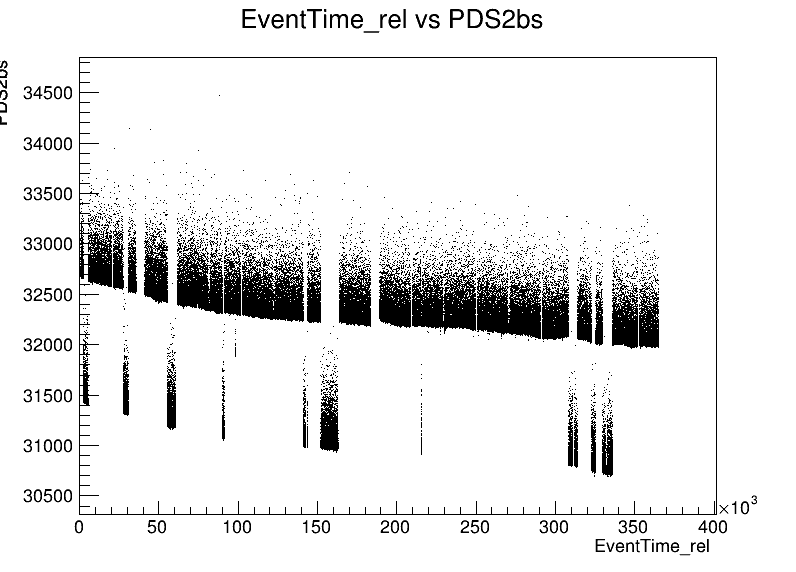

In [14]:
%jsroot off

g = df[det].Graph("EventTime_rel", "PDS2bs")
g2 = df[det].Graph("EventTime_rel", "PTOFamps")
g3 = df[det].Graph("EventTime_rel", "PTOFchisq")

g.Draw("AP")
#g.GetYaxis().SetRangeUser(31000,38000)
#g2.Draw("same AP*")
c.SetLogy(0)
c.Draw()


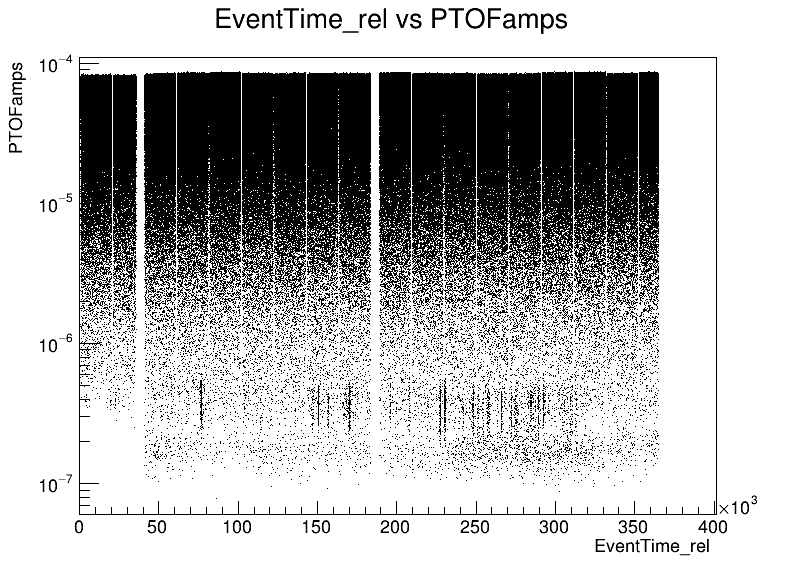

In [15]:
%jsroot off

g2 = df[det].Graph("EventTime_rel", "PTOFamps")
g2.Draw("AP")
g2.GetYaxis().SetRangeUser(6e-8,1.1e-4)
c.SetLogy(1)
c.Draw()

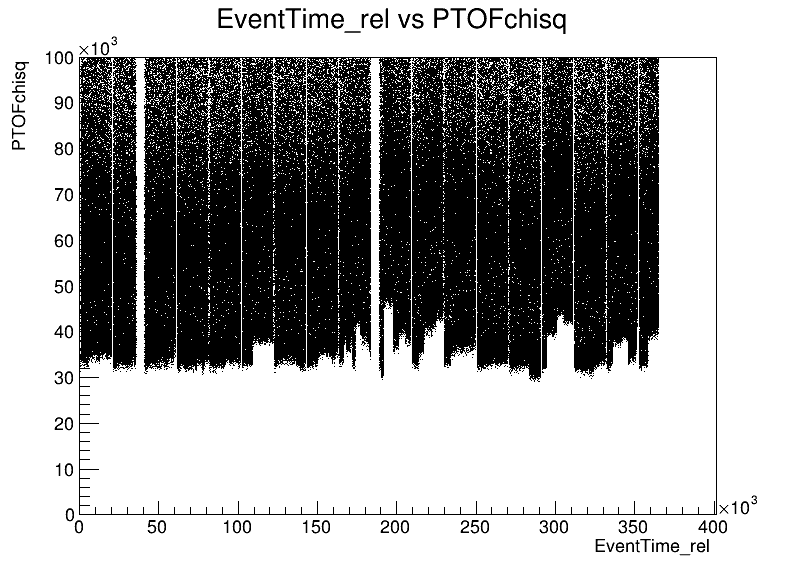

In [16]:
g3.Draw("AP")
g3.GetYaxis().SetRangeUser(0,100000)
c.SetLogy(0)
c.Draw()

In [17]:
#df[det] = df[det].Filter("EventTime_rel<36000 || EventTime_rel>60000")
#df[det] = df[det].Filter("SeriesNumber!=23240112011558")\
#                 .Filter("SeriesNumber>=23240111143943")\
#                 .Filter("SeriesNumber!=23240115124153")\
#                 .Filter("SeriesNumber!=23240119000258")\
#                 .Filter("SeriesNumber!=23240122031038")
                 #.Filter("SeriesNumber!=23240121011940")

#.Filter("SeriesNumber!=23240112011558")\ # remove series right after miniflash
#.Filter("SeriesNumber>=23240111143943")\ # remove series with bad PCS1 parasitic power 
#.Filter("SeriesNumber>=23240110143009") # remove series with high rate???

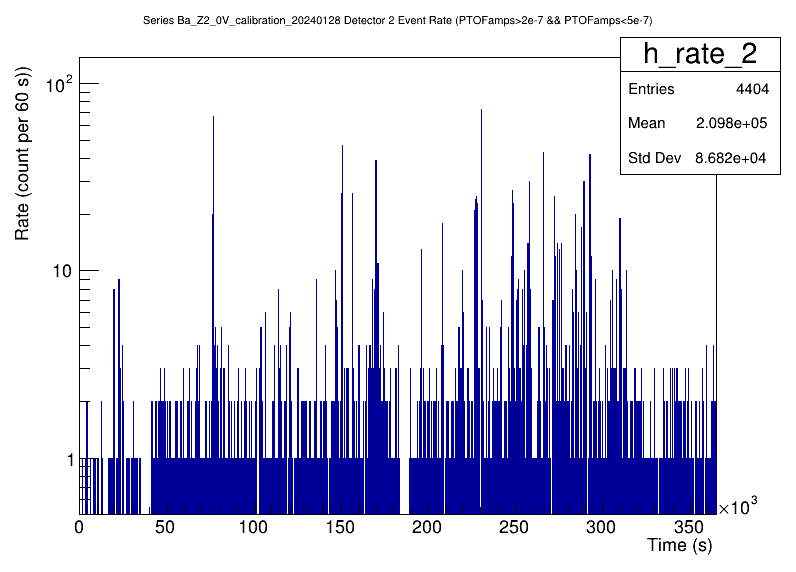

In [18]:
# event rate
%jsroot off

t_max    = df[det].Max("EventTime_rel").GetValue()
sampling = 60 # Sampling rate in seconds; adjust as desired
bins     = round(t_max/sampling)

#c_rate = TCanvas("c_rate", "", 1000, 1200)

#hists_rate = {}

#p = c_rate.cd(det)

#cut = "PTSumamps<6e-7"
#cut = "PTSumamps<6e-7"
cut = "PTOFamps>2e-7 && PTOFamps<5e-7"


h = df[det].Filter(cut)\
           .Histo1D(
                (
                    f"h_rate_{det}",
                    f"Series {series} Detector {det} Event Rate ({cut});Time (s);Rate (count per {sampling} s))",
                    bins,
                    0, t_max
                ),
           "EventTime_rel"
)
h.Draw()
c.SetLogy(1)
c.Draw()

In [19]:
# identify high trigger rate period

trigger_rate_threshold = 4

# convert TH1D to a 2D numpy array
num_bins = h.GetNbinsX()

x_values = np.array([h.GetBinCenter(i) for i in range(1, num_bins+1)])
y_values = np.array([h.GetBinContent(i) for i in range(1, num_bins+1)])

high_trigger_rate_points = x_values[y_values>trigger_rate_threshold]

#print (high_trigger_rate_points)
trigger_spike_cuts = []
trigger_spike_cut_allinone = "EventTime_rel>40000"
for point in high_trigger_rate_points:
    trigger_spike_cuts.append("EventTime_rel<"+str(point-sampling)+" || EventTime_rel>"+str(point+sampling))
    trigger_spike_cut_allinone += " && (EventTime_rel<"+str(point-sampling)+" || EventTime_rel>"+str(point+sampling)+")"
pprint(len(trigger_spike_cuts))

#for 

#numpy_2d_array = np.column_stack((x_values, y_values))

#print (numpy_2d_array)
print(trigger_spike_cuts)

139
['EventTime_rel<19651.187869822486 || EventTime_rel>19771.187869822486', 'EventTime_rel<22531.36143984221 || EventTime_rel>22651.36143984221', 'EventTime_rel<76234.59779750164 || EventTime_rel>76354.59779750164', 'EventTime_rel<76294.60141354373 || EventTime_rel>76414.60141354373', 'EventTime_rel<76534.61587771204 || EventTime_rel>76654.61587771204', 'EventTime_rel<76594.61949375411 || EventTime_rel>76714.61949375411', 'EventTime_rel<76654.62310979619 || EventTime_rel>76774.62310979619', 'EventTime_rel<76714.62672583827 || EventTime_rel>76834.62672583827', 'EventTime_rel<78094.70989480606 || EventTime_rel>78214.70989480606', 'EventTime_rel<81034.88708086786 || EventTime_rel>81154.88708086786', 'EventTime_rel<103956.2684089415 || EventTime_rel>104076.2684089415', 'EventTime_rel<106596.4275147929 || EventTime_rel>106716.4275147929', 'EventTime_rel<113736.85782380014 || EventTime_rel>113856.85782380014', 'EventTime_rel<113796.86143984222 || EventTime_rel>113916.86143984222', 'EventTim

In [20]:
# important! may want to comment out

#df[det] = df[det].Filter("EventTime_rel<0 || EventTime_rel>1500")\
#                 .Filter("EventTime_rel<11000 || EventTime_rel>13000")\
#                 .Filter("EventTime_rel<18000 || EventTime_rel>20000")


#df[det] = df[det].Filter("EventTime_rel<75000 || EventTime_rel>78000")\
#                 .Filter("EventTime_rel<148000 || EventTime_rel>153000")\
#                 .Filter("EventTime_rel<155000 || EventTime_rel>158000")\
#                 .Filter("EventTime_rel<169000 || EventTime_rel>171000")\
#                 .Filter("EventTime_rel>40000")

#print(df[det].Count().GetValue())

In [21]:
df[det] = df[det].Filters(trigger_spike_cuts)

# below are two equivalent cuts

#df[det] = df[det].Filter("EventTime_rel>40000")\
#                 .Filters(trigger_spike_cuts)

#df[det] = df[det].Filter(trigger_spike_cut_allinone)

In [22]:
# extract event number
#npp = df[det].Filter("PTOFamps>0")\
#             .Filter("TriggerType == 2")\
#             .Filter("PTOFamps>1.6e-7 && PTOFamps<1.7e-7")\
#             .Filter("SeriesNumber == 23240105062513")\
#             .Filter("EventNumber>70000 && EventNumber<80000")\
#             .AsNumpy(["SeriesNumber","EventNumber", "PTOFamps", "PTOFchisq"])

In [23]:
#print(df[det].Count().GetValue())

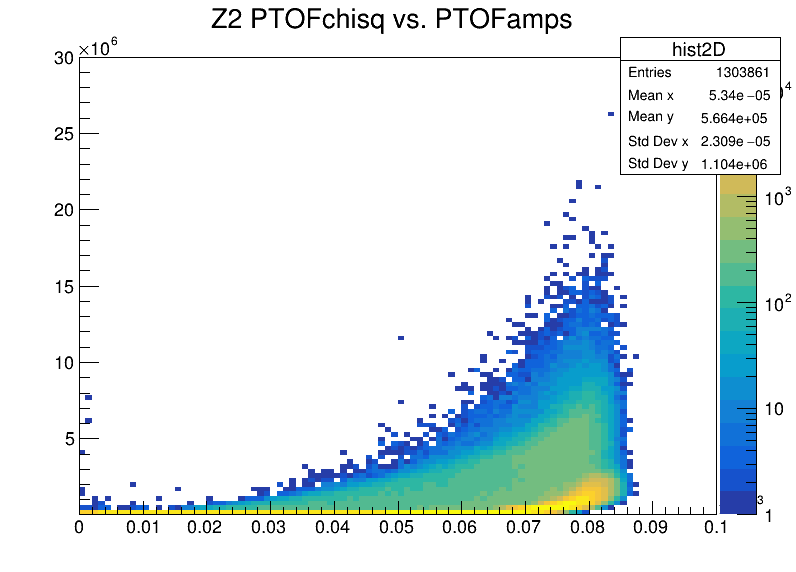

In [24]:
%jsroot off

h = df[det].Histo2D(("hist2D", "Z2 PTOFchisq vs. PTOFamps", 100, 0, 1e-4, 100, 25000, 30000000), "PTOFamps", "PTOFchisq")

h.Draw("COLZ")

c.SetLogy(0)
c.SetLogz(1)
c.Draw()

'(50000000000.0*pow(PTOFamps,1.43)+52000.0)>PTOFchisq'

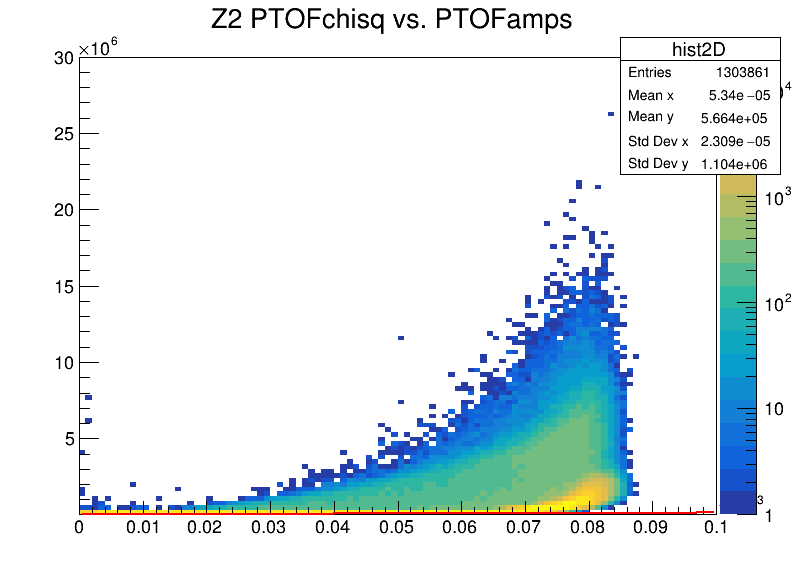

In [25]:
f = ROOT.TF1('f','([0]*pow(x,[1])+[2])')
f.SetParameters(5e10,1.43,52000)

h.Draw("COLZ")
f.Draw("same")
c.SetLogy(0)
c.SetLogz(1)
c.Draw()

chisq_cut = make_cut(f, "PTOFamps", "PTOFchisq")
chisq_cut

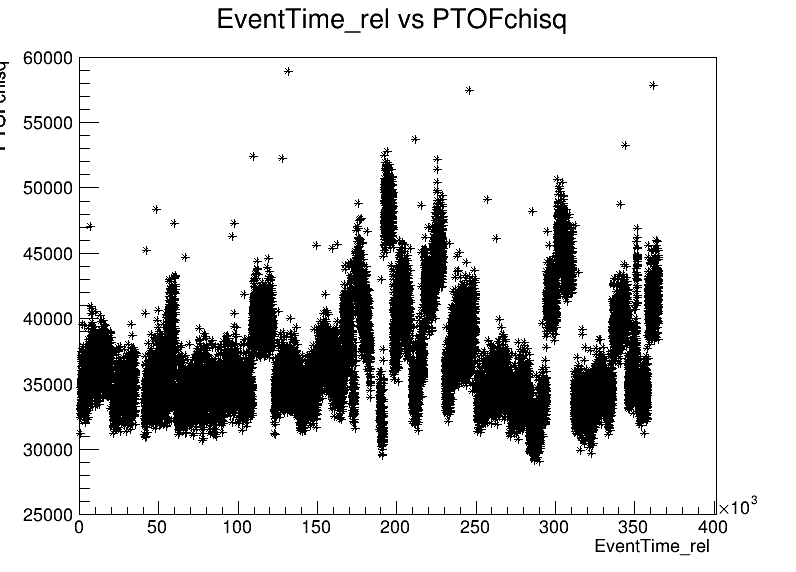

In [26]:
g3 = df[det].Filter("PTOFamps<3e-6")\
            .Graph("EventTime_rel", "PTOFchisq")

g3.Draw("AP*")
g3.GetYaxis().SetRangeUser(25000, 60000)
c.SetLogy(0)
c.Draw()

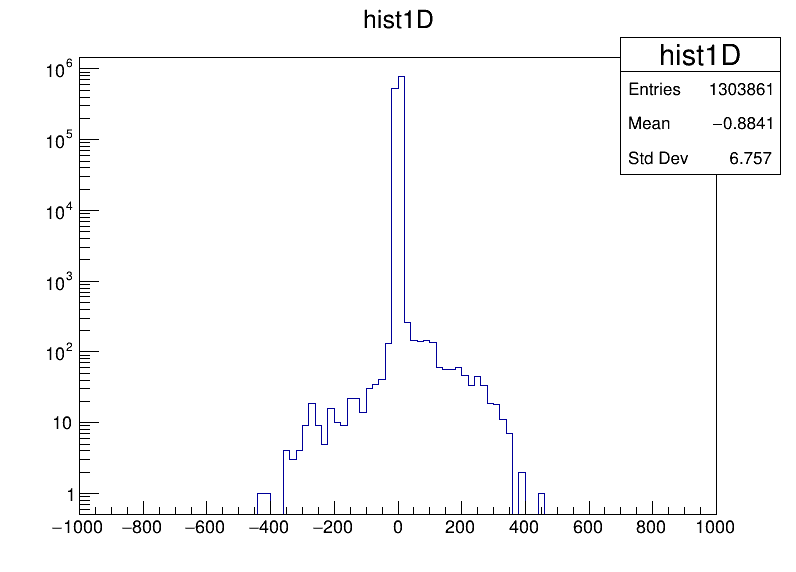

In [27]:
h = df[det].Histo1D(("hist1D","hist1D",100,-1000,1000),"R_timediff")

h.Draw()
c.SetLogy(1)
c.Draw()

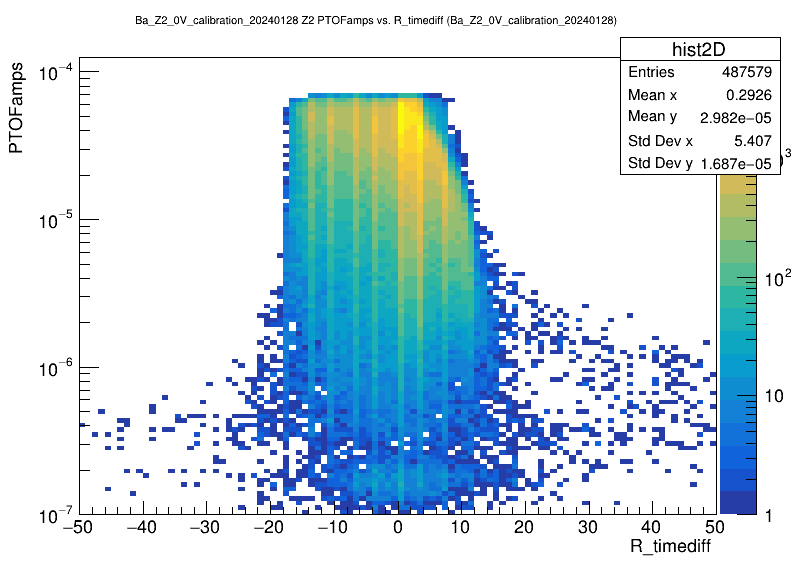

In [28]:
h = df[det].Filter(chisq_cut)\
           .Histo2D(("hist2D",series+ " Z" + str(det) +" PTOFamps vs. R_timediff (" + series_dict[series]+ ");R_timediff;PTOFamps",100,-50,50,100,np.logspace(-7, -3.9, 101)),"R_timediff","PTOFamps")
           #.Filter("PTOFchisq<60000")\
#.Histo2D(("hist2D","hist2D",100,-800,800,100,0,1.2e-4),"R_timediff","PTOFamps")

h.Draw("COLZ")

c.SetLogy(1)
c.SetLogz(1)
c.Draw()

#t = df[2].Filter("PTOFamps>1.04e-4").Count()
#print (t.GetValue())

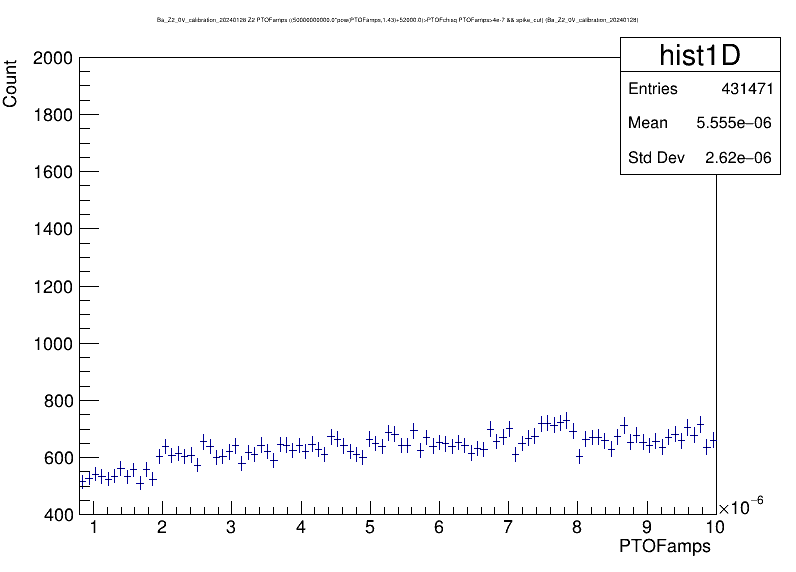

In [29]:
#timediff_cut = "R_timediff<20 && PTOFchisq<60000 && PTOFamps>2e-7"
#timediff_cut = "PTOFchisq<60000 && PTOFamps>3e-7 && R_timediff<-2"
#timediff_cut = "PTOFchisq<80000 && PTSumamps>3e-7 && R_timediff<-4 && PDS2bs<33500"
timediff_cut = "PTOFamps>4e-7"


%jsroot off

#SeriesNumber<23240122162045 && SeriesNumber>=23240119111659 && SeriesNumber>=23240115043241 && SeriesNumber>=23240109153905
#h = df[det].Filter("SeriesNumber>23240100000000 || SeriesNumber<23240130000000")\
#           .Filter("SeriesNumber<23240115000000 && SeriesNumber>23240111000000")\
h = df[det].Filter(chisq_cut)\
           .Filter(timediff_cut)\
           .Filter("EventTime_rel>38000")\
           .Histo1D(("hist1D",series+ " Z" + str(det) +" PTOFamps (" + chisq_cut + " " + timediff_cut + " && spike_cut) (" + series_dict[series]+ ");PTOFamps;Count",100,8e-7,1e-5),"PTOFamps")

# -5, 30


#h = df[det].Filter(chisq_cut)\
#           .Filter(timediff_cut)\
#           .Filter("PTSumamps>0")\
#           .Histo1D(("hist1D",series+ " Z" + str(det) +" PTSumamps (" + chisq_cut + " " + timediff_cut + " && spike_cut) (" + series_dict[series]+ ");PSumamps;Count",100,3e-7,1e-5),"PTSumamps")

h.Draw("E")
h.GetYaxis().SetRangeUser(400,2000)
c.SetLogy(0)
c.Draw()

 FCN=124.33 FROM MIGRAD    STATUS=CONVERGED     111 CALLS         112 TOTAL
                     EDM=6.75486e-08    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   2.8 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           5.40764e+01   3.79797e+00  -3.73629e-03   5.33883e-05
   2  p1           1.94920e-06   3.99183e-08   4.92747e-11  -4.56788e+03
   3  p2           1.00000e-07     fixed    
   4  p3          -5.87883e+02   3.79673e+00  -2.34701e-03  -5.79223e-05
   5  p4           7.21444e+01   1.17980e+01  -1.76626e-03  -1.44791e-05
   6  p5           7.64624e-06   5.91659e-08   8.31707e-11   5.88306e+03
   7  p6           3.00000e-07     fixed    


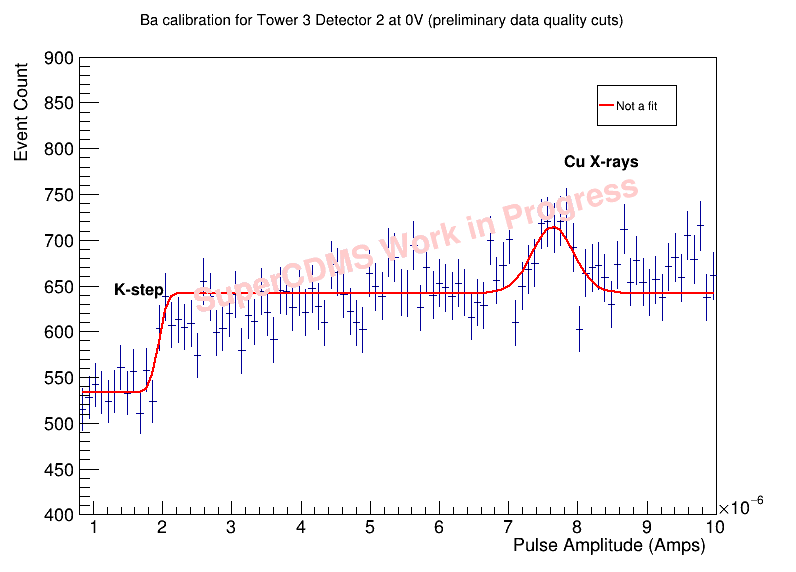

In [30]:
# Define the error function
def error_function(x, params):
    return params[0] * ROOT.TMath.Erf((x[0] - params[1]) / (np.sqrt(2) * params[2])) - params[3] + params[4]*ROOT.TMath.Gaus(x[0], params[5], params[6])

# Create a TF1 object with the error function
fit_function = ROOT.TF1("fit_function", error_function, 0.8e-6, 1e-5, 7)

# Set initial parameters for the fit
fit_function.SetParameter(0, 43)  # Amplitude
fit_function.SetParameter(1, 2e-6)     # Mean
fit_function.FixParameter(2, 1e-7)     # Standard deviation
fit_function.SetParameter(3, -500)     # baseline
fit_function.SetParameter(4, 72)      # amplitude
fit_function.SetParameter(5, 7.64e-6)
fit_function.FixParameter(6, 3e-7)

# Fit the histogram with the error function
h.Fit("fit_function", "R")

#h.Scale(1./87./3600.)
h.Draw("E")
h.GetYaxis().SetRangeUser(400,900)
h.SetTitle("Ba calibration for Tower 3 Detector 2 at 0V (preliminary data quality cuts)")
h.GetXaxis().SetTitle("Pulse Amplitude (Amps)")
h.GetYaxis().SetTitle("Event Count")
c.SetLogy(0)
h.SetStats(0)
ROOT.gStyle.SetOptFit(0000)  
c.Draw()

legend = ROOT.TLegend(0.75, 0.78, 0.85, 0.85)
#legend.AddEntry(h, "Data", "l")
legend.AddEntry(fit_function, "Not a fit", "l")

fit_function.Draw("same")

legend.Draw()

text1 = ROOT.TText(1.3e-6, 640, "K-step")
text1.SetTextSize(0.03)
text1.Draw()

text2 = ROOT.TText(7.8e-6, 780, "Cu X-rays")
text2.SetTextSize(0.03)
text2.Draw()

text5 = ROOT.TText(2.5e-6, 620, "SuperCDMS Work in Progress")
text5.SetTextColorAlpha(ROOT.kRed-10, 1)
text5.SetTextSize(0.06)
text5.SetTextAngle(15);
text5.Draw()

In [31]:
h = df[det].Filter(timediff_cut)\
           .Filter("PTSumamps>6e-7")\
           .Filter("PTSumamps<1e-5")\
           .Histo2D(("name", "name", 50, 6e-7, 1e-5, 50, 25000, 80000,), "PTSumamps", "PTOFchisq")
           #.AsNumpy(["PTOFchisq","PTSumamps"])

h.Draw()
c.Draw()

#npp

runtime_error: Template method resolution failed:
  ROOT::RDF::RInterface<ROOT::Detail::RDF::RJittedFilter,void> ROOT::RDF::RInterface<ROOT::Detail::RDF::RJittedFilter,void>::Filter(basic_string_view<char,char_traits<char> > expression, basic_string_view<char,char_traits<char> > name = "") =>
    runtime_error: 
RDataFrame: An error occurred during just-in-time compilation. The lines above might indicate the cause of the crash
 All RDF objects that have not run an event loop yet should be considered in an invalid state.

  ROOT::RDF::RInterface<ROOT::Detail::RDF::RJittedFilter,void> ROOT::RDF::RInterface<ROOT::Detail::RDF::RJittedFilter,void>::Filter(basic_string_view<char,char_traits<char> > expression, basic_string_view<char,char_traits<char> > name = "") =>
    runtime_error: 
RDataFrame: An error occurred during just-in-time compilation. The lines above might indicate the cause of the crash
 All RDF objects that have not run an event loop yet should be considered in an invalid state.


input_line_434:2:23: error: use of undeclared identifier 'PTSumamps'
auto func150(){return PTSumamps>6e-7
                      ^
input_line_438:2:23: error: use of undeclared identifier 'PTSumamps'
auto func150(){return PTSumamps>6e-7
                      ^


In [ ]:
# convert TH1D to a 2D numpy array
num_bins = h.GetNbinsX()

x_values = np.array([h.GetBinCenter(i) for i in range(1, num_bins+1)])
y_values = np.array([h.GetBinContent(i) for i in range(1, num_bins+1)])

numpy_2d_array = np.column_stack((x_values, y_values))

#print(numpy_2d_array)

In [ ]:
print(df[det].GetColumnNames())

In [ ]:
npp = df[det].Filter(timediff_cut)\
             .Filter("PTSumamps>8e-7 && PTSumamps<8e-6")\
             .AsNumpy(["PTOFamps", "PTSumamps", "SeriesNumber", "DumpNumber", "EventNumber"])

In [ ]:
with open ("ba_post_6th_bake_ongoing_aftercuts_forAta_v1.npy", "wb") as f:
    np.save(f, npp["PTOFamps"])

In [ ]:
npp = df[det].Filter("EventNumber>80000 && EventNumber<90000")\
             .Filter("SeriesNumber == 23231224132204")\
           .AsNumpy(["PTOFamps","EventNumber","SeriesNumber"])

In [ ]:
npp = df[det].Filter("PTOFamps>0")\
             .Filter("TriggerType == 1")\
             .Filter("PTOFamps<5e-7")\
             .Filter("SeriesNumber == 23240112123746")\
             .Filter("PTOFchisq<60000")\
             .Filter("PDS1min<-0.08")\
             .Filter("EventNumber>80000 && EventNumber<90000")\
             .AsNumpy(["SeriesNumber","EventNumber", "PTSumamps", "PTOFamps", "PTOFchisq"])

In [ ]:
npp = df[det].Filter("PTOFamps>0")\
             .Filter("TriggerType == 1")\
             .Filter("PTOFamps>7.6e-6 && PTOFamps<7.7e-6")\
             .Filter("SeriesNumber == 23240105062513")\
             .Filter("EventNumber>80000 && EventNumber<90000")\
             .AsNumpy(["SeriesNumber","EventNumber", "PTOFamps", "PTOFchisq"])

In [ ]:
npp = df[det].Filter("PTOFamps>0")\
             .Filter("TriggerType == 1")\
             .Filter("SeriesNumber == 23240103200057")\
             .Filter("EventNumber>80000 && EventNumber<90000")\
             .AsNumpy(["SeriesNumber","EventNumber", "PTOFamps", "PTOFchisq"])

In [ ]:
npp = df[det].Filter("PTOFchisq<37000 && PTSumamps<5e-7  && PTOFchisqLF<1200")\
             .Filter("DumpNumber == 32")\
             .AsNumpy(["SeriesNumber","DumpNumber","EventNumber", "PTOFamps", "PTOFchisq","PTOFchisqLF"])

In [ ]:
npp

In [ ]:
for series_num, dump_num, event_num in npp["SeriesNumber"]:
    print (int(series_num))

In [ ]:
g3 = df[det].Filter("PTOFchisq<60000 && PTOFamps<5e-7")\
            .Graph("PDS1minbin","PDS1min")

g3.Draw("AP")
c.SetLogy(0)
c.Draw()

In [ ]:
# get a list of EventNumber to plot raw pulses
evs_list = list(npp["EventNumber"].astype(int))

print(evs_list)

#evs_list = evs_list[1]

#evs_list = [80200, 80205, 80206, 80242, 80326, 80345]

In [ ]:
series = "23240105_062513"


series = "23240111_073252" # good amplification
series = "23240112_123746" # bad amplification
series = "23240102_071256" # Z2 90V low bg

#s3df directory
rawfpath = "/fs/ddn/sdf/group/supercdms/data/CDMS/CUTE/R37/Raw/"+series+"/"+series+"_F0032.mid.gz"

#filepath = "/fs/ddn/sdf/group/supercdms/data/CDMS/CUTE/R37/Raw/23231223_143801/23231223_143801_F0005.mid.gz"


myreader = rawio.RawDataReader(rawfpath)

In [ ]:
# access raw pulses
events = myreader.read_events(output_format=2,
                                  skip_empty=True,
                                  event_nums=evs_list[:],
                                  #event_nums=[80861],
                                  #nb_events=10,
                                  trigger_types=[1],
                                  detector_nums=[det],
                                  channel_names=chanNames)

In [ ]:
#events

In [ ]:
pt_events = plot_raw_traces(events[:15], det, chanNames=chanNames, filter="butter", zoom=True)

evs = list(npp["PTOFamps"].astype(float))
print("PTOFamps: ", evs[0])
evs = list(npp["PTOFchisq"].astype(float))
print("PTOFchisq: ", evs[0])

In [ ]:
for id in range(5,6):
    plt.plot(butter_lowpass_filter(pt_events[id],10)[100:])

In [ ]:
len(evs_list)

In [ ]:
plt.plot(pt_events[6])